In [ ]:
import 

# load the lut

In [72]:
fn = pl.Path('data/lut_mfrsr2pwv_0.1.nc').resolve()
ds = xr.open_dataset(fn)
ds = ds.assign_coords(air_mass = 1 / np.cos(np.deg2rad(ds.solar_zenith_angle)))
da_trans = np.exp(-ds.optical_depth)

sh: 1: getfattr: not found


# The convolution

## get a filter function

In [2]:
serialno = 648
p2cal = pl.Path(f'/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/cals/V0{serialno}_28523D.SPR')

In [3]:
p2cal.exists()

True

In [4]:
import atmPy.data_archives.NOAA_ESRL_GMD_GRAD.cal_facility.lab as atmcf

In [5]:
ds = atmcf.read_mfrsr_cal(p2cal)

## interpolate on luts wavenumbers

In [7]:
respondsfct = ds.responds.sel(channel = 940)

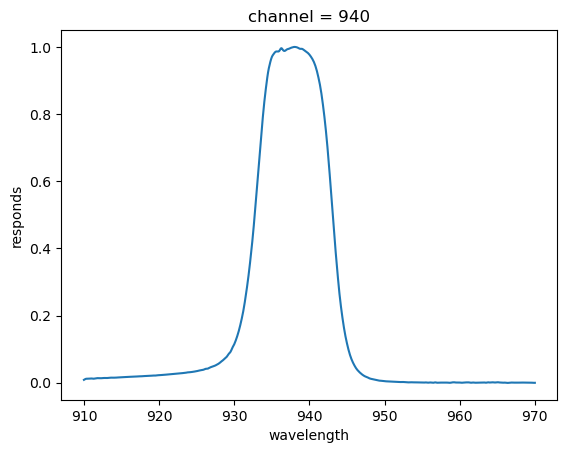

In [8]:
respondsfct.plot()

In [9]:
# convert to wavenumbers
respondsfct = respondsfct.assign_coords(wavenumber = 1e7/respondsfct.wavelength)
respondsfct = respondsfct.swap_dims({'wavelength': 'wavenumber'})

In [27]:
respondsfct_intp = respondsfct.interp(wavenumber = da_trans.wavenumber, method = 'linear')

In [29]:
# wheigh lut with respondsfunction
da_trans_weighted = respondsfct_intp * da_trans

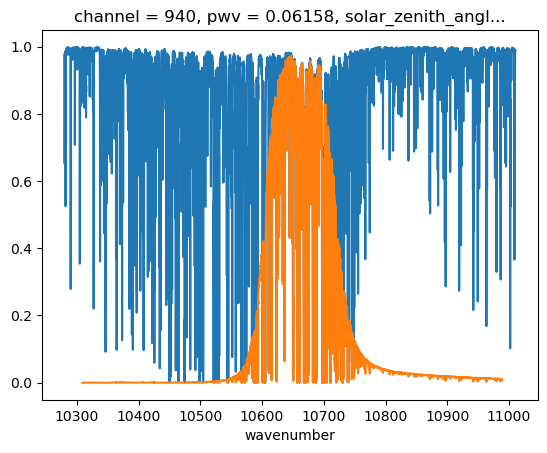

In [30]:
da_trans.isel(pwv = 5, solar_zenith_angle = 5).plot()
da_trans_weighted.isel(pwv = 5, solar_zenith_angle = 5).plot()

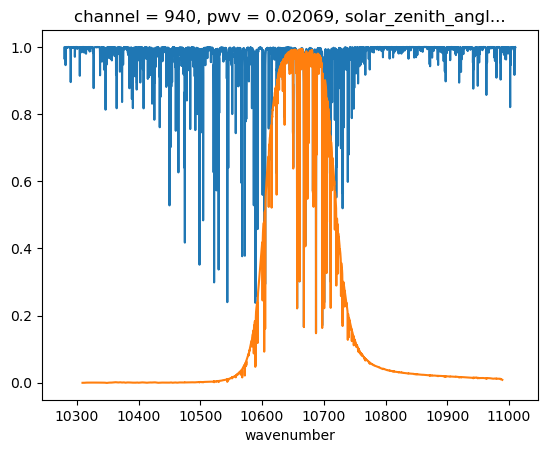

In [90]:
da_trans.isel(pwv = 2, solar_zenith_angle = 0).plot()
da_trans_weighted.isel(pwv = 2, solar_zenith_angle = 0).plot()

In [80]:
da_trans_weighted_projected = da_trans_weighted.sum('wavenumber')/respondsfct_intp.sum('wavenumber')

In [81]:
da_od_projection = - np.log(da_trans_weighted_projected)

In [85]:
da_od_projection_am = da_od_projection.swap_dims({'solar_zenith_angle': 'air_mass'})

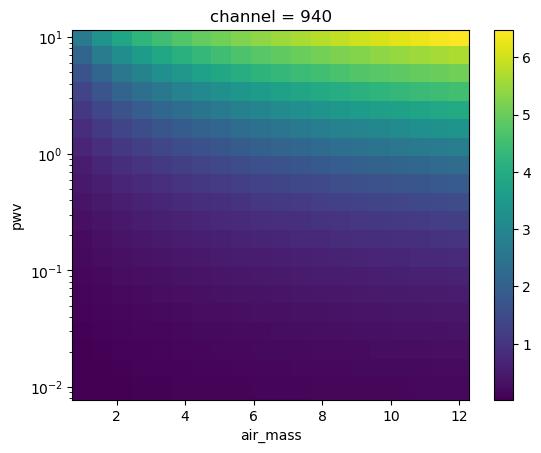

In [89]:
f,a = plt.subplots()
da_od_projection_am.plot()
a.set_yscale('log')

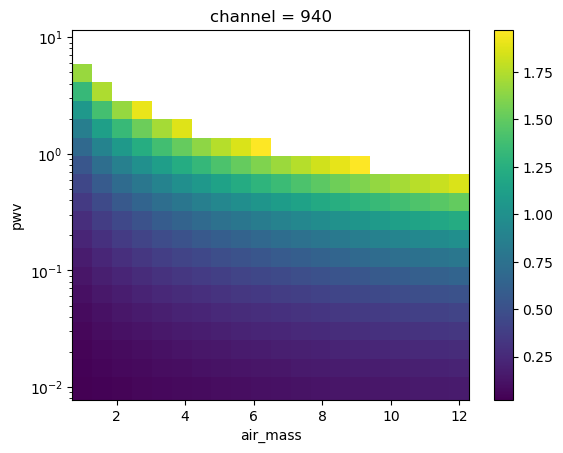

In [159]:
f,a = plt.subplots()
da_od_projection_am.where(da_od_projection_am < 2).plot()
a.set_yscale('log')

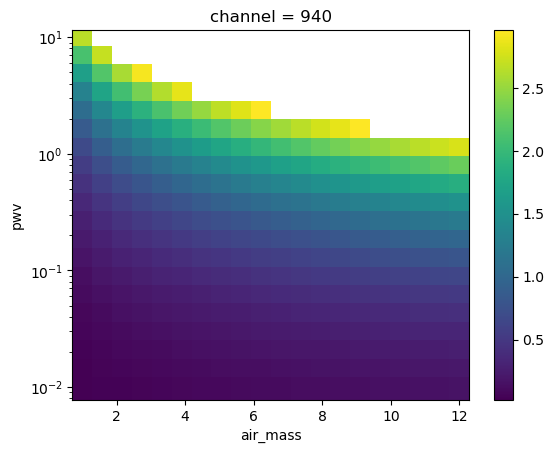

In [160]:
f,a = plt.subplots()
da_od_projection_am.where(da_od_projection_am < 3).plot()
a.set_yscale('log')

In [ ]:
ds = xr.Dataset({'optical_depth':da_od_projection_am})
attrs = {"title": "Lookup table for precipitable water retrieval from MFRSR 940 nm channel",
         "product": "mfrsr_pwv_lut"}
ds.attrs = attrs
# ds.to_netcdf('data/pwd_od_lut_648.nc')

# The LUT from scratch

## The lookuptable boundaries.

* Absolute lower end (polar/high-alt winter): ~0.05–0.1 mm (rare), 0.2–0.5 mm (very dry but observed), 1–3 mm (common on Antarctic plateau/Atacama winters).
* Dry subtropics & high deserts (low–mid elev.): 3–15 mm typical, 20–25 mm on humid days.
* Mid-lat maritime/humid: 10–35 mm typical, 40–50 mm during warm spells.
* Tropics over warm oceans: 35–60 mm typical; 65–75 mm in very moist conditions.
* Extremes (atmospheric rivers/equatorial maxima): ~75–85 mm have been observed; >85 mm is extraordinary and short-lived.

In [55]:
#airmass
am_min = 1
am_max = 12
am_range = np.linspace(am_min,am_max, 20)
am_range

array([ 1.        ,  1.57894737,  2.15789474,  2.73684211,  3.31578947,
        3.89473684,  4.47368421,  5.05263158,  5.63157895,  6.21052632,
        6.78947368,  7.36842105,  7.94736842,  8.52631579,  9.10526316,
        9.68421053, 10.26315789, 10.84210526, 11.42105263, 12.        ])

In [56]:
#solar zenith angle range
za_range = 90 - np.rad2deg(np.arcsin(1/am_range))
za_range

array([ 0.        , 50.70351976, 62.39233194, 68.5687455 , 72.4470349 ,
       75.12229379, 77.08358265, 78.58484226, 79.7717435 , 80.7340715 ,
       81.53027352, 82.20007441, 82.77143647, 83.26462257, 83.69468068,
       84.07302295, 84.40846294, 84.70791642, 84.9768867 , 85.21980815])

In [57]:
# pmv
pwv_min = 0.01
pwv_max = 10
pwv_range = np.logspace(np.log10(pwv_min), np.log10(pwv_max), 20)
pwv_range

array([ 0.01      ,  0.0143845 ,  0.02069138,  0.02976351,  0.04281332,
        0.06158482,  0.08858668,  0.1274275 ,  0.18329807,  0.26366509,
        0.37926902,  0.54555948,  0.78475997,  1.12883789,  1.62377674,
        2.33572147,  3.35981829,  4.83293024,  6.95192796, 10.        ])

## Make the LBLrtm LUT

In [58]:
import tapefive.lab as tf

In [59]:
reload(tf)
reload(tf.tape5parser)
reload(tf.tools)
reload(tf.fileio)

<module 'tapefive.fileio' from '/home/hagen/prog/tapefive/tapefive/fileio.py'>

In [60]:
%%time
pwv1norm = 0.3458833686192847

# pwv = 1
dslist_pwv = []
for pwv in pwv_range:
    dslist_za = []
    for z in za_range:
        print('.', end = '')
        run = tf.Lblrtm(verbose=False)
        run.configuration.spectral_grid.fmax = tf.tools.nm_to_inv_cm(910)
        run.configuration.spectral_grid.fmin = tf.tools.nm_to_inv_cm(970)
        run.configuration.spectral_grid.layering_control = 'exact'
        run.configuration.spectral_grid.df = 0.05
        run.configuration.atmospheric_layers
        run.configuration.geometry.slant_angle = z
        run.configuration.rayleigh.enabled = False
        run.configuration.molecular_spectral_lines.molecules.H2O.enable = True
        run.configuration.molecular_spectral_lines.molecules.H2O.enable_continuum = True
        run.configuration.molecular_spectral_lines.molecules.H2O.scale = pwv1norm * pwv # 
        run.configuration.molecular_spectral_lines.molecules.H2O.scale_unit = 'direct'
        run_dir = run
        res_dir = run.run()
        dslist_za.append(res_dir.data.optical_depth.expand_dims(dim = {'solar_zenith_angle': [z]}))
    da =xr.concat(dslist_za, 'solar_zenith_angle')
    dslist_pwv.append(da.expand_dims(dim = {'pwv': [pwv]}))
ds = xr.concat(dslist_pwv, 'pwv')

................................................................................................................................................................................................................................................................................................................................................................................................................CPU times: user 930 ms, sys: 162 ms, total: 1.09 s
Wall time: 2min 43s


In [31]:
fn = pl.Path('data/lut_mfrsr2pwv_0.1.nc').resolve()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [159]:
if not fn.exists():
    ds.to_netcdf(fn)
else:
    print('file exists')

sh: 1: getfattr: not found


PermissionError: [Errno 13] Permission denied: '/home/hagen/projecte/mfrsr2pwv/data/lut_mfrsr2pwv_0.1.nc'

In [42]:
fn = pl.Path('data/lut_mfrsr2pwv_0.1.nc').resolve()
ds = xr.open_dataset(fn)
ds = ds.assign_coords(air_mass = 1 / np.cos(np.deg2rad(ds.solar_zenith_angle)))
da_trans = np.exp(-ds.optical_depth)

sh: 1: getfattr: not found


In [47]:
da_trans.wavenumber.shape

(14601,)

In [49]:
da_sum = da_trans.sum('wavenumber')/da_trans.wavenumber.shape[0]

In [50]:
da_sum_am = da_sum.swap_dims({'solar_zenith_angle':'air_mass'})

Text(0.5, 1.0, 'this is transmittance, not od!!')

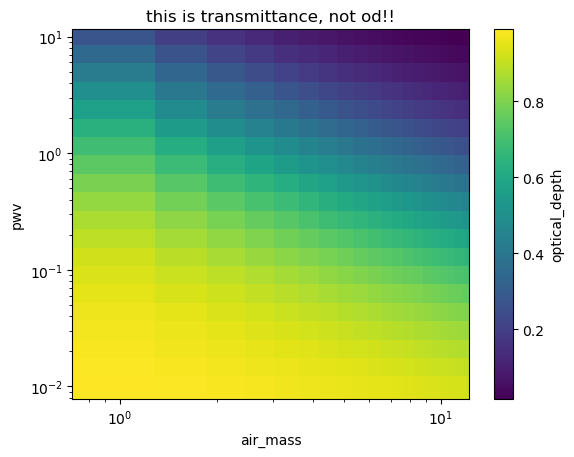

In [51]:
f,a = plt.subplots()
pc = da_sum_am.plot(x = 'air_mass', ax = a)
a.set_yscale('log')
a.set_xscale('log')
a.set_title("this is transmittance, not od!!")

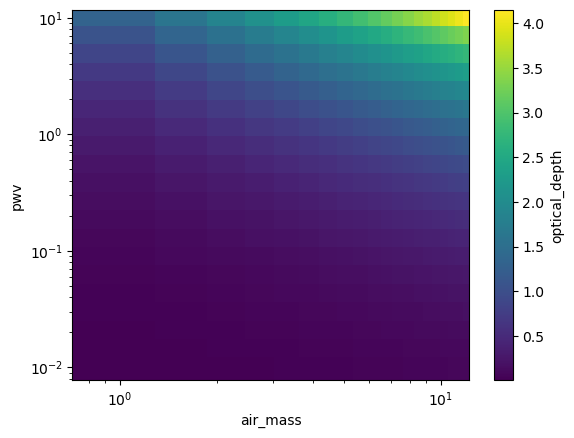

In [66]:
f,a = plt.subplots()
(- np.log(da_sum_am)).plot(ax = a)
a.set_yscale('log')
a.set_xscale('log')
# a.set_xlim(1,90)

## find best cm resolution for lut

### based on OD

Conclusion: 0.05 looks fine to me

In [ ]:
import tapefive.lab as tf

In [2]:
reload(tf)
reload(tf.tape5parser)
reload(tf.tools)
reload(tf.fileio)

<module 'tapefive.fileio' from '/home/hagen/prog/tapefive/tapefive/fileio.py'>

In [12]:
import scipy as sp

In [40]:
pwv1norm = 0.3458833686192847
pwv = 1
z = 0
df = 0.0025
od1 = None
while 1:
    run = tf.Lblrtm(verbose=False)
    run.configuration.spectral_grid.fmax = tf.tools.nm_to_inv_cm(910)
    run.configuration.spectral_grid.fmin = tf.tools.nm_to_inv_cm(970)
    run.configuration.spectral_grid.layering_control = 'exact'
    df *= 1.1
    run.configuration.spectral_grid.df = df
    run.configuration.atmospheric_layers
    run.configuration.geometry.slant_angle = z
    run.configuration.rayleigh.enabled = False
    run.configuration.molecular_spectral_lines.molecules.H2O.enable = True
    run.configuration.molecular_spectral_lines.molecules.H2O.enable_continuum = True
    run.configuration.molecular_spectral_lines.molecules.H2O.scale = pwv1norm * pwv # 
    run.configuration.molecular_spectral_lines.molecules.H2O.scale_unit = 'direct'
    run_dir = run
    res_dir = run.run()
    ds = res_dir.data
    od = ds.optical_depth.sum()/ds.wavenumber.shape[0]
    if isinstance(od1, type(None)):
        od1 = od
        continue
    else:
        print(f'df = {df:0.3f}, odratio = {od1/od:0.4f}')
    

df = 0.003, odratio = 1.0000
df = 0.003, odratio = 1.0000
df = 0.004, odratio = 1.0000
df = 0.004, odratio = 1.0000
df = 0.004, odratio = 1.0000
df = 0.005, odratio = 1.0000
df = 0.005, odratio = 1.0000
df = 0.006, odratio = 1.0000
df = 0.006, odratio = 1.0000
df = 0.007, odratio = 1.0000
df = 0.008, odratio = 1.0000
df = 0.009, odratio = 1.0000
df = 0.009, odratio = 1.0000
df = 0.010, odratio = 1.0000
df = 0.011, odratio = 1.0000
df = 0.013, odratio = 1.0000
df = 0.014, odratio = 1.0000
df = 0.015, odratio = 1.0000
df = 0.017, odratio = 1.0000
df = 0.019, odratio = 1.0000
df = 0.020, odratio = 1.0000
df = 0.022, odratio = 1.0000
df = 0.025, odratio = 1.0000
df = 0.027, odratio = 1.0001
df = 0.030, odratio = 1.0000
df = 0.033, odratio = 1.0001
df = 0.036, odratio = 1.0001
df = 0.040, odratio = 1.0001
df = 0.044, odratio = 1.0001
df = 0.048, odratio = 1.0001
df = 0.053, odratio = 1.0000
df = 0.058, odratio = 1.0000
df = 0.064, odratio = 0.9999
df = 0.070, odratio = 0.9999
df = 0.077, od

KeyboardInterrupt: 

In [18]:
run = tf.Lblrtm(verbose=False)
run.configuration.spectral_grid.fmax = tf.tools.nm_to_inv_cm(910)
run.configuration.spectral_grid.fmin = tf.tools.nm_to_inv_cm(970)
run.configuration.spectral_grid.layering_control = 'exact'
df *= 1.1
run.configuration.spectral_grid.df = 0.05
run.configuration.atmospheric_layers
run.configuration.geometry.slant_angle = 0
run.configuration.rayleigh.enabled = False
run.configuration.molecular_spectral_lines.molecules.H2O.enable = True
run.configuration.molecular_spectral_lines.molecules.H2O.enable_continuum = True
run.configuration.molecular_spectral_lines.molecules.H2O.scale = pwv1norm * 1 # 
run.configuration.molecular_spectral_lines.molecules.H2O.scale_unit = 'direct'
run_dir = run
res_dir = run.run()

da = res_dir.data.optical_depth

In [19]:
da

<xarray.DataArray 'optical_depth' (wavenumber: 14601)> Size: 117kB
array([0.09661572, 0.12589198, 0.1730688 , ..., 0.05798897, 0.05985783,
       0.04110217], shape=(14601,))
Coordinates:
  * wavenumber  (wavenumber) float64 117kB 1.028e+04 1.028e+04 ... 1.101e+04
Attributes:
    long_name:  optical_depth
    units:      1

In [20]:
%matplotlib inline

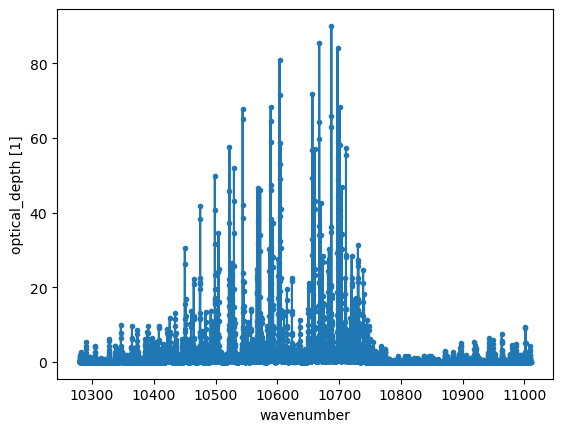

In [21]:
f, a = plt.subplots()
da.plot(marker = '.', ax= a)

#### what about od vs transmittance

In [212]:
od_d = da.sum()/da.wavenumber.shape[0]

dat = np.exp(-da)
od_t = - np.log(dat.sum()/da.wavenumber.shape[0])


In [25]:
print(f'od_direct: {od_d:0.2f}, od_t')

od_direct: 1.13, od_t


In [26]:
1/od_d

<xarray.DataArray 'optical_depth' ()> Size: 8B
array(0.88174458)

In [30]:
a = 5
b = 3
np.log(a/b), np.log(a) - np.log(b)
np.log(a+b), np.log(a) * np.log(b)

(np.float64(2.0794415416798357), np.float64(1.7681482684484517))

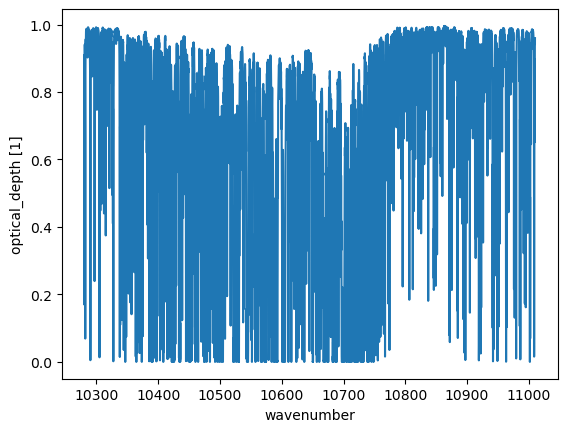

In [11]:
dat.plot()

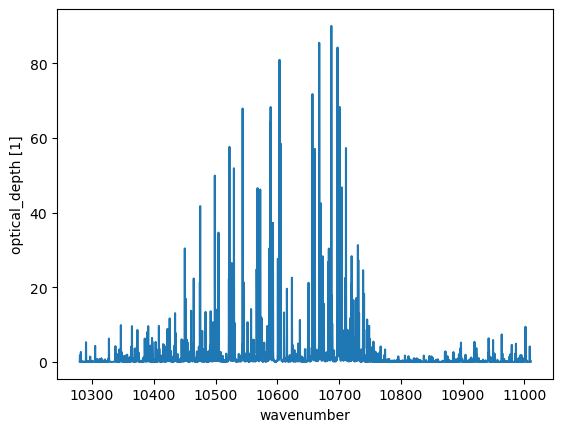

In [12]:
da.plot()

### Based on transmittance

Conclusion: same: 0.05 looks fine to me

In [1]:
import tapefive.lab as tf

In [2]:
reload(tf)
reload(tf.tape5parser)
reload(tf.tools)
reload(tf.fileio)

<module 'tapefive.fileio' from '/home/hagen/prog/tapefive/tapefive/fileio.py'>

In [3]:
import scipy as sp

In [16]:
pwv1norm = 0.3458833686192847
pwv = 1
z = 0
df = 0.0025
od1 = None
while 1:
    run = tf.Lblrtm(verbose=False)
    run.configuration.spectral_grid.fmax = tf.tools.nm_to_inv_cm(910)
    run.configuration.spectral_grid.fmin = tf.tools.nm_to_inv_cm(970)
    run.configuration.spectral_grid.layering_control = 'exact'
    df *= 1.1
    run.configuration.spectral_grid.df = df
    run.configuration.atmospheric_layers
    run.configuration.geometry.slant_angle = z
    run.configuration.rayleigh.enabled = False
    run.configuration.molecular_spectral_lines.molecules.H2O.enable = True
    run.configuration.molecular_spectral_lines.molecules.H2O.enable_continuum = True
    run.configuration.molecular_spectral_lines.molecules.H2O.scale = pwv1norm * pwv # 
    run.configuration.molecular_spectral_lines.molecules.H2O.scale_unit = 'direct'
    run_dir = run
    res_dir = run.run()
    ds = res_dir.data
    da = ds.optical_depth
    od = da.sum()/da.wavenumber.shape[0]
    dat = np.exp(-da)
    trans = - np.log(dat.sum()/da.wavenumber.shape[0])
    if isinstance(od1, type(None)):
        od1 = od
        trans1 = trans
        continue
    else:
        print(f'df = {df:0.3f}, odratio = {od1/od:0.4f}, transratio = {trans1/trans:0.4f}')
    

df = 0.003, odratio = 1.0000, transratio = 1.0000
df = 0.003, odratio = 1.0000, transratio = 1.0000
df = 0.004, odratio = 1.0000, transratio = 1.0000
df = 0.004, odratio = 1.0000, transratio = 1.0000
df = 0.004, odratio = 1.0000, transratio = 1.0000
df = 0.005, odratio = 1.0000, transratio = 1.0000
df = 0.005, odratio = 1.0000, transratio = 1.0000
df = 0.006, odratio = 1.0000, transratio = 1.0000
df = 0.006, odratio = 1.0000, transratio = 1.0000
df = 0.007, odratio = 1.0000, transratio = 1.0000
df = 0.008, odratio = 1.0000, transratio = 1.0000
df = 0.009, odratio = 1.0000, transratio = 1.0000
df = 0.009, odratio = 1.0000, transratio = 1.0000
df = 0.010, odratio = 1.0000, transratio = 1.0000
df = 0.011, odratio = 1.0000, transratio = 1.0000
df = 0.013, odratio = 1.0000, transratio = 1.0000
df = 0.014, odratio = 1.0000, transratio = 1.0000
df = 0.015, odratio = 1.0000, transratio = 1.0000
df = 0.017, odratio = 1.0000, transratio = 1.0000
df = 0.019, odratio = 1.0000, transratio = 1.0000


KeyboardInterrupt: 

In [50]:
run = tf.Lblrtm(verbose=False)
run.configuration.spectral_grid.fmax = tf.tools.nm_to_inv_cm(910)
run.configuration.spectral_grid.fmin = tf.tools.nm_to_inv_cm(970)
run.configuration.spectral_grid.layering_control = 'exact'
df *= 1.1
run.configuration.spectral_grid.df = 0.05
run.configuration.atmospheric_layers
run.configuration.geometry.slant_angle = 0
run.configuration.rayleigh.enabled = False
run.configuration.molecular_spectral_lines.molecules.H2O.enable = True
run.configuration.molecular_spectral_lines.molecules.H2O.enable_continuum = True
run.configuration.molecular_spectral_lines.molecules.H2O.scale = pwv1norm * 1 # 
run.configuration.molecular_spectral_lines.molecules.H2O.scale_unit = 'direct'
run_dir = run
res_dir = run.run()

In [51]:
da = res_dir.data.optical_depth

In [52]:
da

<xarray.DataArray 'optical_depth' (wavenumber: 14601)> Size: 117kB
array([0.09661572, 0.12589198, 0.1730688 , ..., 0.05798897, 0.05985783,
       0.04110217], shape=(14601,))
Coordinates:
  * wavenumber  (wavenumber) float64 117kB 1.028e+04 1.028e+04 ... 1.101e+04
Attributes:
    long_name:  optical_depth
    units:      1

In [53]:
%matplotlib widget

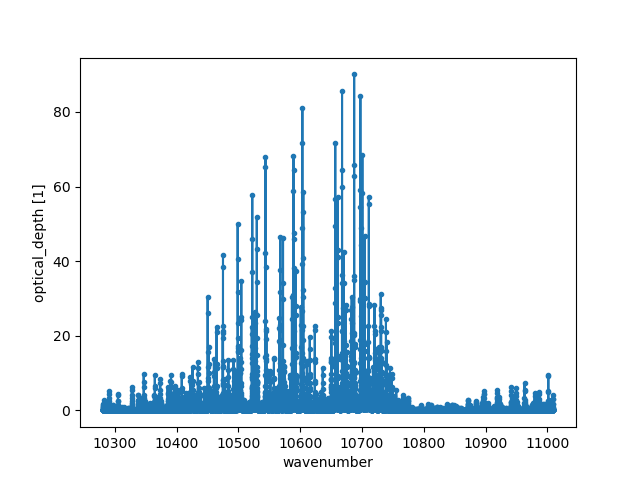

In [54]:
f, a = plt.subplots()
da.plot(marker = '.', ax= a)

## Effects from pwv vs effects from airmass

If we had a simple linear system, we would assume doubling concentration or doubling the path, will both double the optical depth. However this is not the case.

In [99]:
import tapefive.lab as tf

In [106]:
multiplyers = list(range(1,11))
pwv1norm = 0.3458833686192847


In [152]:
# startvalues
pwvs = 1
ams = 1

pwvlist = []
for m in multiplyers:
    print('.', end = '')
    run = tf.Lblrtm(verbose=False)
    run.configuration.spectral_grid.fmax = tf.tools.nm_to_inv_cm(910)
    run.configuration.spectral_grid.fmin = tf.tools.nm_to_inv_cm(970)
    run.configuration.spectral_grid.layering_control = 'exact'
    run.configuration.spectral_grid.df = 0.05
    run.configuration.atmospheric_layers
    run.configuration.geometry.slant_angle = np.rad2deg(np.arccos(1/ams))
    run.configuration.rayleigh.enabled = False
    run.configuration.molecular_spectral_lines.molecules.H2O.enable = True
    run.configuration.molecular_spectral_lines.molecules.H2O.enable_continuum = True
    run.configuration.molecular_spectral_lines.molecules.H2O.scale = pwv1norm * pwvs * m # 
    run.configuration.molecular_spectral_lines.molecules.H2O.scale_unit = 'direct'
    run_dir = run
    res_dir = run.run()
    da = res_dir.data.optical_depth
    da = da.expand_dims(dim = {'multiplyer': [m]})
    pwvlist.append(da)


..........

In [153]:
amslist = []
for m in multiplyers:
    print('.', end = '')
    run = tf.Lblrtm(verbose=False)
    run.configuration.spectral_grid.fmax = tf.tools.nm_to_inv_cm(910)
    run.configuration.spectral_grid.fmin = tf.tools.nm_to_inv_cm(970)
    run.configuration.spectral_grid.layering_control = 'exact'
    run.configuration.spectral_grid.df = 0.05
    run.configuration.atmospheric_layers
    run.configuration.geometry.slant_angle = np.rad2deg(np.arccos(1/(ams * m)))
    run.configuration.rayleigh.enabled = False
    run.configuration.molecular_spectral_lines.molecules.H2O.enable = True
    run.configuration.molecular_spectral_lines.molecules.H2O.enable_continuum = True
    run.configuration.molecular_spectral_lines.molecules.H2O.scale = pwv1norm * pwvs # 
    run.configuration.molecular_spectral_lines.molecules.H2O.scale_unit = 'direct'
    run_dir = run
    res_dir = run.run()
    da = res_dir.data.optical_depth
    da = da.expand_dims(dim = {'multiplyer': [m]})
    amslist.append(da)

..........

In [154]:
dapwv = xr.concat(pwvlist, 'multiplyer')
daams = xr.concat(amslist, 'multiplyer')

In [155]:
def od_eff(da):
    dat = np.exp(-da)
    teff = dat.sum('wavenumber')/da.wavenumber.shape[0]
    odeff = - np.log(teff)
    return odeff

In [156]:
dapwveff = od_eff(dapwv)
daameff = od_eff(daams)

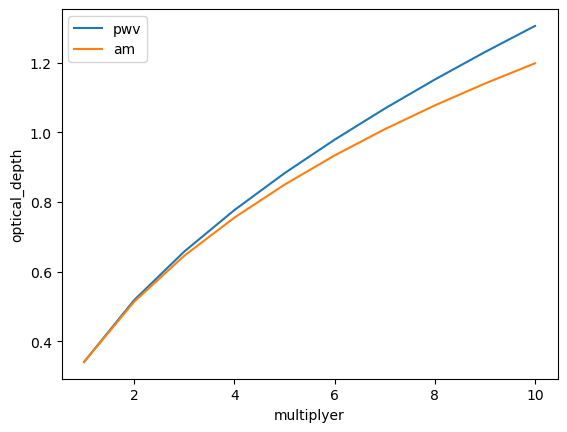

In [158]:
f,a = plt.subplots()
dapwveff.plot(ax = a, label = 'pwv')
daameff.plot(ax = a, label = 'am')
a.legend()

(2.5, 4.0)

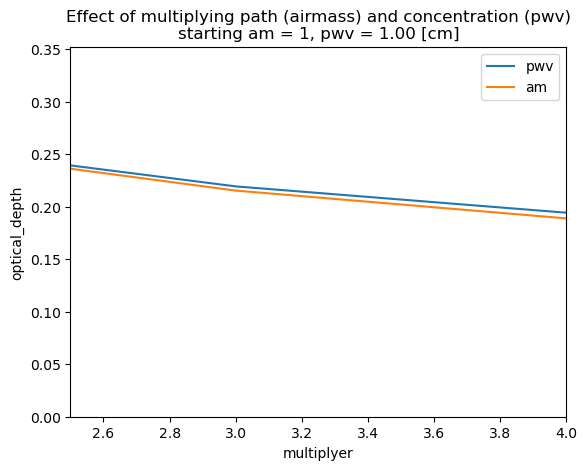

In [162]:
f,a = plt.subplots()
(dapwveff/multiplyers).plot(ax = a, label = 'pwv')
(daameff /multiplyers).plot(ax = a, label = 'am')
a.legend()
a.set_title(f'Effect of multiplying path (airmass) and concentration (pwv)\nstarting am = 1, pwv = {pwvs:0.2f} [cm]')
a.set_ylim(bottom = 0)
a.set_xlim(2.5, 4)

Text(0.5, 0, 'transmittance')

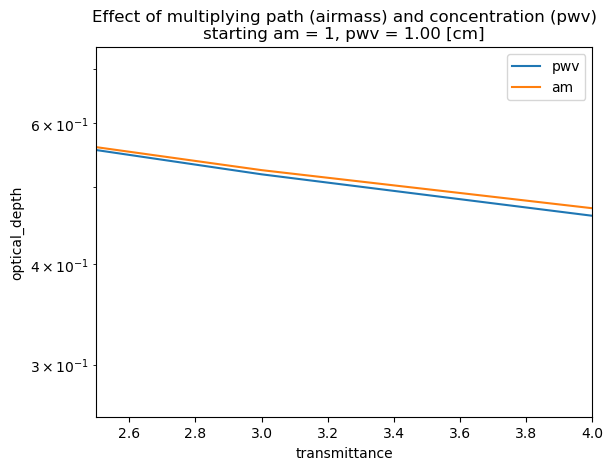

In [168]:
# simulation of langley proceedure
f,a = plt.subplots()
(np.exp(-dapwveff)).plot(ax = a, label = 'pwv')
(np.exp(-daameff)).plot(ax = a, label = 'am')
a.legend()
a.set_title(f'Effect of multiplying path (airmass) and concentration (pwv)\nstarting am = 1, pwv = {pwvs:0.2f} [cm]')
a.set_yscale('log')
# a.set_ylim(bottom = 0)
a.set_xlim(2.5, 4)
a.set_xlabel('transmittance')

(0.0, 0.3518315312157013)

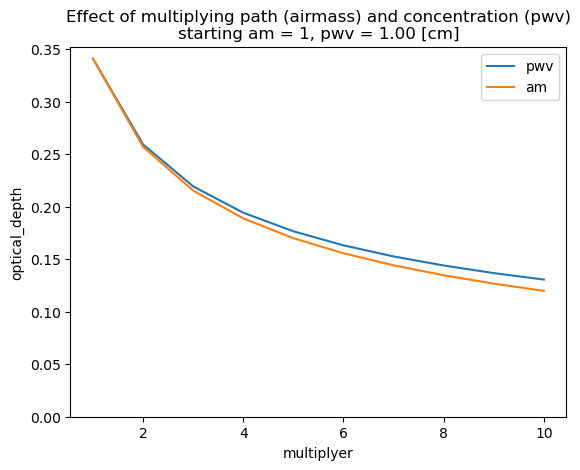

In [157]:
f,a = plt.subplots()
(dapwveff/multiplyers).plot(ax = a, label = 'pwv')
(daameff /multiplyers).plot(ax = a, label = 'am')
a.legend()
a.set_title(f'Effect of multiplying path (airmass) and concentration (pwv)\nstarting am = 1, pwv = {pwvs:0.2f} [cm]')
a.set_ylim(bottom = 0)

(0.0, 1.3519450485322448)

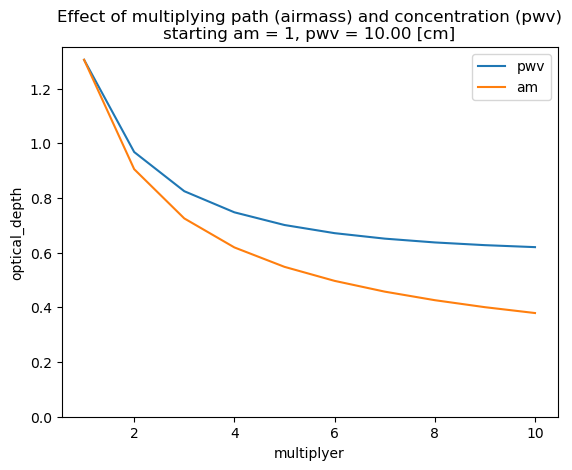

In [151]:
f,a = plt.subplots()
(dapwveff/multiplyers).plot(ax = a, label = 'pwv')
(daameff /multiplyers).plot(ax = a, label = 'am')
a.legend()
a.set_title(f'Effect of multiplying path (airmass) and concentration (pwv)\nstarting am = 1, pwv = {pwvs:0.2f} [cm]')
a.set_ylim(bottom = 0)

(0.0, 0.0011287630753914416)

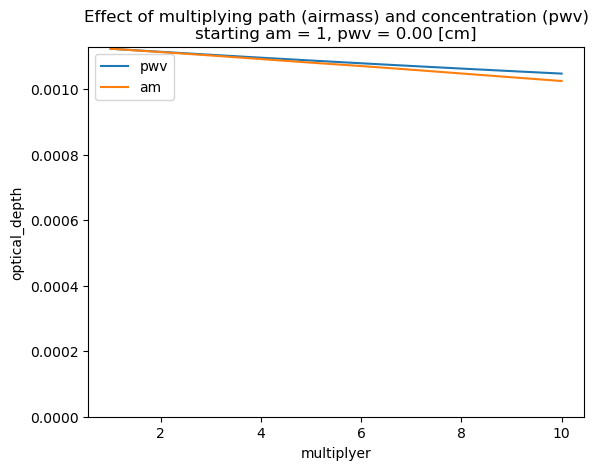

In [144]:
f,a = plt.subplots()
(dapwveff/multiplyers).plot(ax = a, label = 'pwv')
(daameff /multiplyers).plot(ax = a, label = 'am')
a.legend()
a.set_title(f'Effect of multiplying path (airmass) and concentration (pwv)\nstarting am = 1, pwv = {pwvs:0.2f} [cm]')
a.set_ylim(bottom = 0)